In [1]:
# setup
import sys
import os
sys.path.append(os.path.abspath('../src'))

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from model_helpers import preprocess_data, validate_data, predict_psp_probabilities

data_location = '../data/raw/psp_raw_data.xlsx'

In [2]:
# Load the pickled model
with open('../models/psp_model.pkl', 'rb') as model_file:
    psp_pipeline = pickle.load(model_file)

In [3]:
# Load and preprocess data
df = pd.read_excel(data_location, index_col=0)
df = preprocess_data(df)
print(validate_data(df))

Validation complete and successful.
None


In [4]:
# define fee structure
fee_mapping = [
    ('Moneycard', 5, 2),  # ('psp', success_fee, unsuccessful_fee)
    ('Goldcard', 10, 5),
    ('UK_Card', 3, 1),
    ('Simplecard', 1, 0.5)
]

# Create the DataFrame
fee_df = pd.DataFrame(fee_mapping, columns=['psp', 'success_fee', 'unsuccessful_fee'])

# Save to CSV
fee_df.to_csv('../data/raw/psp_fees.csv', index=False)

# Output the fee DataFrame
print("Fee mapping saved to CSV:")
display(fee_df)

Fee mapping saved to CSV:


,psp,success_fee,unsuccessful_fee
0,Moneycard,5,2.0
1,Goldcard,10,5.0
2,UK_Card,3,1.0
3,Simplecard,1,0.5


## possible use of model predicitons
- the model runs the feature for each psp and then displays it with the different probabilities

In [5]:
np.random.seed(42)  # For reproducibility

# Generate random data
countries = ['Germany', 'Switzerland', 'Austria']
cards = ['Visa', 'Master', 'Diners']
amounts = np.random.randint(10, 1000, size=10)  # Random amounts between 10 and 1000
secure_flags = np.random.randint(0, 2, size=10)  # Random 0 or 1 for '3d_secured'

# Create the new data DataFrame
new_data = pd.DataFrame({
    'country': np.random.choice(countries, size=10),
    'card': np.random.choice(cards, size=10),
    'amount': amounts,
    '3d_secured': secure_flags
    })

# Get all unique PSPs
psp_list = df['psp'].unique()

# Predict probabilities
probabilities = predict_psp_probabilities(
    model=psp_pipeline.named_steps['classifier'], 
    preprocessor=psp_pipeline.named_steps['preprocessor'], 
    new_transactions=new_data, 
    psp_list=psp_list
)

# Create a DataFrame for the input features
input_data_df = new_data.reset_index(drop=True)

# Convert the probabilities into a DataFrame
probabilities_df = pd.DataFrame(probabilities, columns=psp_list).round(2)
probabilities_df.columns = [f'{col} %' for col in probabilities_df.columns]

# Concatenate the probabilities to the input data
final_df = pd.concat([input_data_df, probabilities_df], axis=1)

# Output the final DataFrame
print("Predicted probabilities for each PSP:")
display(final_df)


Predicted probabilities for each PSP:


,country,card,amount,3d_secured,UK_Card %,Simplecard %,Moneycard %,Goldcard %
0,Switzerland,Visa,112,0,0.54,0.47,0.44,0.53
1,Germany,Visa,445,0,0.45,0.48,0.43,0.55
2,Switzerland,Visa,870,0,0.45,0.50,0.45,0.57
3,Switzerland,Diners,280,0,0.43,0.51,0.52,0.59
4,Switzerland,Diners,116,1,0.53,0.52,0.53,0.63
5,Switzerland,Diners,81,0,0.52,0.50,0.53,0.58
6,Germany,Master,710,1,0.50,0.45,0.55,0.65
7,Germany,Diners,30,1,0.51,0.59,0.56,0.63
8,Switzerland,Master,624,1,0.50,0.45,0.58,0.65
9,Switzerland,Master,131,0,0.52,0.44,0.51,0.59


## Create lookup table for all possible combination (check complexity)

In [6]:
countries = df['country'].unique()
cards = df['card'].unique()
max_amount = df['amount'].max()  # Get the maximum value from the 'amount' column
amounts = np.arange(1, max_amount + 1)  # Create a range from 1 to the maximum value
secure_flags = [0, 1]  # '3d_secured' binary values

# Generate all combinations of country, card, secure flag, and amount
combinations = pd.MultiIndex.from_product(
    [countries, cards, secure_flags, amounts], names=['country', 'card', '3d_secured', 'amount']
)

# Create the new data DataFrame
new_data = pd.DataFrame(index=combinations).reset_index()

# Get all unique PSPs from the original dataframe (replace with your actual dataframe)
psp_list = df['psp'].unique()

# Predict probabilities
probabilities = predict_psp_probabilities(
    model=psp_pipeline.named_steps['classifier'], 
    preprocessor=psp_pipeline.named_steps['preprocessor'], 
    new_transactions=new_data, 
    psp_list=psp_list
)

# Convert the probabilities into a DataFrame
probabilities_df = pd.DataFrame(probabilities, columns=psp_list).round(2)
probabilities_df.columns = [f'{col} %' for col in probabilities_df.columns]

# Concatenate the probabilities to the input data
final_df = pd.concat([new_data, probabilities_df], axis=1)

In [7]:
new_data_filtered = final_df[final_df['amount'] > 100]
new_data_filtered.head()

,country,card,3d_secured,amount,UK_Card %,Simplecard %,Moneycard %,Goldcard %
100,Germany,Visa,0,101,0.53,0.48,0.44,0.52
101,Germany,Visa,0,102,0.53,0.48,0.43,0.52
102,Germany,Visa,0,103,0.53,0.48,0.43,0.52
103,Germany,Visa,0,104,0.53,0.48,0.43,0.52
104,Germany,Visa,0,105,0.53,0.48,0.43,0.52


- The amount adds a lot of complexity due to it's granularity
- can be binned if we add more payment providers, cards,... (out of scope here)

In [8]:
# get fee structure
fee_df = pd.read_csv('../data/raw/psp_fees.csv', index_col=False)
fee_df

,psp,success_fee,unsuccessful_fee
0,Moneycard,5,2.0
1,Goldcard,10,5.0
2,UK_Card,3,1.0
3,Simplecard,1,0.5


### define logic for psp selection, needs to be discussed with Stakeholders!!!

In [9]:
# Add a column for selected_psp based on highest probability
def select_psp(row):
    highest_prob_psp = row[psp_list].idxmax()
    return highest_prob_psp

In [10]:
# Clean up the probabilities column names to match the PSP names
probabilities_df.columns = probabilities_df.columns.str.replace(' %', '')

# Concatenate the probabilities with the input data
final_df = pd.concat([new_data, probabilities_df], axis=1)

fee_df = pd.read_csv('../data/raw/psp_fees.csv', index_col=False)

# Apply the selection logic to the final DataFrame to create a 'selected_psp' column
final_df['selected_psp'] = final_df.apply(select_psp, axis=1)

# Merge the fee DataFrame to get the correct fees based on the selected PSP
final_df = final_df.merge(fee_df, left_on='selected_psp', right_on='psp', how='left')
final_df.drop(columns="psp", inplace=True)

# Output the updated final DataFrame with selected PSP and fees
print("Final DataFrame with Selected PSP and Fees:")
display(final_df)


Final DataFrame with Selected PSP and Fees:


,country,card,3d_secured,amount,UK_Card,Simplecard,Moneycard,Goldcard,selected_psp,success_fee,unsuccessful_fee
0,Germany,Visa,0,1,0.53,0.50,0.49,0.54,Goldcard,10,5.0
1,Germany,Visa,0,2,0.53,0.50,0.49,0.54,Goldcard,10,5.0
2,Germany,Visa,0,3,0.53,0.50,0.49,0.54,Goldcard,10,5.0
3,Germany,Visa,0,4,0.53,0.50,0.49,0.54,Goldcard,10,5.0
4,Germany,Visa,0,5,0.53,0.50,0.49,0.54,Goldcard,10,5.0
...,...,...,...,...,...,...,...,...,...,...,...
11335,Switzerland,Master,1,626,0.50,0.45,0.58,0.65,Goldcard,10,5.0
11336,Switzerland,Master,1,627,0.50,0.45,0.58,0.65,Goldcard,10,5.0
11337,Switzerland,Master,1,628,0.50,0.45,0.58,0.65,Goldcard,10,5.0
11338,Switzerland,Master,1,629,0.50,0.45,0.58,0.65,Goldcard,10,5.0


In [11]:
selected_psp_counts = final_df['selected_psp'].value_counts()
selected_psp_counts

selected_psp
Goldcard      10871
UK_Card         245
Moneycard       121
Simplecard      103
Name: count, dtype: int64

- heavily favors Goldcard, that's the most expensive one 

## alternative implementation that chooses cheapest psp when within 5% of best performing

In [12]:
def select_psp(row):
    # Get the PSP probabilities for this row
    prob_values = row[psp_list]
    
    # Find the PSP with the highest probability
    highest_prob_psp = prob_values.idxmax()
    highest_prob_value = prob_values.max()

    # Get the PSPs that are within 5% of the highest probability
    close_psps = prob_values[prob_values >= (highest_prob_value * 0.95)]

    # If there's more than one PSP with similar probability, choose the cheapest based on the fee structure
    if len(close_psps) > 1:
        # Get the corresponding success fees for the PSPs in close_psps
        fees = fee_df.set_index('psp').loc[close_psps.index, 'success_fee']
        
        # Choose the PSP with the minimum fee
        cheapest_psp = fees.idxmin()
        return cheapest_psp
    else:
        # If there's no close match, return the one with the highest probability
        return highest_prob_psp


In [13]:
# Clean up the probabilities column names to match the PSP names
probabilities_df.columns = probabilities_df.columns.str.replace(' %', '')

# Concatenate the probabilities with the input data
final_df = pd.concat([new_data, probabilities_df], axis=1)

fee_df = pd.read_csv('../data/raw/psp_fees.csv', index_col=False)

# Apply the selection logic to the final DataFrame to create a 'selected_psp' column
final_df['selected_psp'] = final_df.apply(select_psp, axis=1)

# Merge the fee DataFrame to get the correct fees based on the selected PSP
final_df = final_df.merge(fee_df, left_on='selected_psp', right_on='psp', how='left')
final_df.drop(columns="psp", inplace=True)

# Output the updated final DataFrame with selected PSP and fees
print("Final DataFrame with Selected PSP and Fees:")
display(final_df)
selected_psp_counts = final_df['selected_psp'].value_counts()
selected_psp_counts

Final DataFrame with Selected PSP and Fees:


,country,card,3d_secured,amount,UK_Card,Simplecard,Moneycard,Goldcard,selected_psp,success_fee,unsuccessful_fee
0,Germany,Visa,0,1,0.53,0.50,0.49,0.54,UK_Card,3,1.0
1,Germany,Visa,0,2,0.53,0.50,0.49,0.54,UK_Card,3,1.0
2,Germany,Visa,0,3,0.53,0.50,0.49,0.54,UK_Card,3,1.0
3,Germany,Visa,0,4,0.53,0.50,0.49,0.54,UK_Card,3,1.0
4,Germany,Visa,0,5,0.53,0.50,0.49,0.54,UK_Card,3,1.0
...,...,...,...,...,...,...,...,...,...,...,...
11335,Switzerland,Master,1,626,0.50,0.45,0.58,0.65,Goldcard,10,5.0
11336,Switzerland,Master,1,627,0.50,0.45,0.58,0.65,Goldcard,10,5.0
11337,Switzerland,Master,1,628,0.50,0.45,0.58,0.65,Goldcard,10,5.0
11338,Switzerland,Master,1,629,0.50,0.45,0.58,0.65,Goldcard,10,5.0


selected_psp
Goldcard      9921
Simplecard     538
UK_Card        500
Moneycard      381
Name: count, dtype: int64

In [14]:
# Calculate the average probability for each PSP (for all PSPs: UK_Card, Simplecard, Moneycard, Goldcard)
average_probabilities = final_df[psp_list].mean()
average_probabilities

UK_Card       0.479371
Simplecard    0.494919
Moneycard     0.517101
Goldcard      0.600343
dtype: float32

- changes distribution a litte, goldccard has the highest probabilities overall 
- could change the threshold further (instead of 5% could use 10%?)

## Visualize probabiities per amount

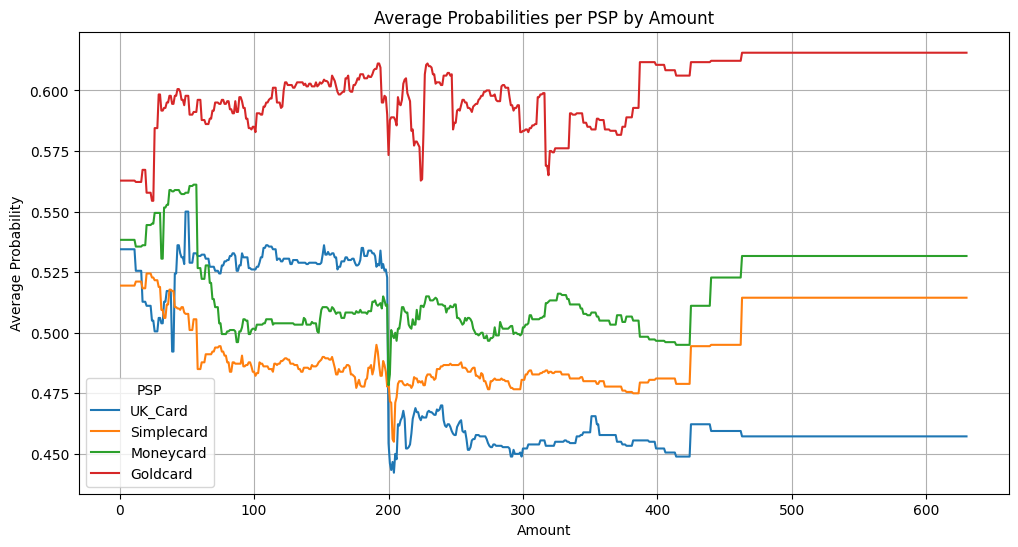

In [15]:
# Assuming final_df contains PSP probability columns like 'UK_Card', 'Simplecard', etc.
psp_list = df['psp'].unique()

# Group by 'amount' and calculate the mean probability for each PSP
average_probs = final_df.groupby('amount')[psp_list].mean()

# Reshape the data to long format for easier plotting
average_probs_flattened = average_probs.reset_index()

# Melt the DataFrame so each row corresponds to one amount-PSP pair
average_probs_melted = average_probs_flattened.melt(id_vars='amount', value_vars=psp_list, 
                                                    var_name='PSP', value_name='Average_Probability')

# Set the figure size
plt.figure(figsize=(12, 6))

# Create a line plot for each PSP 
sns.lineplot(data=average_probs_melted, x='amount', y='Average_Probability', hue='PSP')

# Add labels and title
plt.xlabel('Amount')
plt.ylabel('Average Probability')
plt.title('Average Probabilities per PSP by Amount')
plt.legend(title='PSP')

# Show the plot
plt.grid(True)
plt.show()

- This gives insights into where we could bin the amount based on prob. 
- Also overall odds bad
- Question if Simpledcard and Moneycard are worth both keeping, Simpledcard is cheaper, but the differenve in odds is minimal